# Sporkful Sandwiches

Sandwich data from a recent [Sporkful podcast episode][sporkful]:

> A while back we had legendary food critic Mimi Sheraton on the show. She told a story about a time she had 104 pastrami sandwiches in her car. She was taking them to a scale to weigh them to see which Jewish deli gave you the biggest sandwich for your money.
> 
> A Sporkful listener named Bill in San Clemente, California, heard that episode and called in with a pretty provocative question...
> 
> __Do places make smaller sandwiches for women?__

[sporkful]: http://www.sporkful.com/is-sandwich-sexism-real/

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats as st

from utils import plt, sns

In [2]:
# Sandwich data is in ounces...
cols = ["female", "deli", "sandwich"]
df = pd.DataFrame([
    # Male sandwiches
    [0, 1, 10.6],
    [0, 2, 22.2],
    [0, 3, 12.0],
    [0, 4, 11.7],
    # Female sandwiches
    [1, 1, 10.9],
    [1, 2, 25.1],
    [1, 3, 10.8],
    [1, 4, 13.7],
], columns=cols)
df.head()

,female,deli,sandwich
0,0,1,10.6
1,0,2,22.2
2,0,3,12.0
3,0,4,11.7
4,1,1,10.9


In [3]:
with pm.Model() as model:
    # Priors
    intercept = pm.Normal("intercept", 0, 10)

    beta_mu = pm.Normal("beta_mu", 0, 10)
    beta_sigma = pm.HalfCauchy("beta_sigma", 2.5)  # Gelman 2006
    beta_nu = pm.Gamma("beta_nu", 2, 0.1)          # From the `Stan` docs
    beta = pm.StudentT("beta", nu=beta_nu, mu=beta_mu, sd=beta_sigma, shape=2)

    theta = intercept + beta[df.female.values]
    sigma = pm.HalfCauchy("sigma", 2.5)

    # Likelihood
    y = pm.Normal("y", mu=theta, sd=sigma, observed=df.sandwich.values)

    # Sample
    trace = pm.sample(draws=5000, njobs=4, chain=4)

burn_in = 1000
trace = trace[burn_in:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -32.429: 100%|██████████| 200000/200000 [00:24<00:00, 8169.39it/s]
Finished [100%]: Average ELBO = -32.434
100%|██████████| 5000/5000 [02:07<00:00, 39.19it/s] 


                 mean         sd  mc_error   hpd_2.5   hpd_97.5
intercept    6.556283   7.241663  0.190410 -6.927662  21.577352
beta_mu      7.103333   7.259046  0.180560 -7.182161  21.457336
beta__0      7.513764   7.323086  0.188947 -6.857916  22.023157
beta__1      7.861853   7.352243  0.193017 -6.358889  22.632140
beta_sigma   2.931568   4.211300  0.068087  0.008829   8.956992
beta_nu     20.118281  14.337337  0.106921  0.621733  48.618317
sigma        6.223644   1.856469  0.020175  3.437708   9.819871


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115e26e90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117ea0350>]], dtype=object)

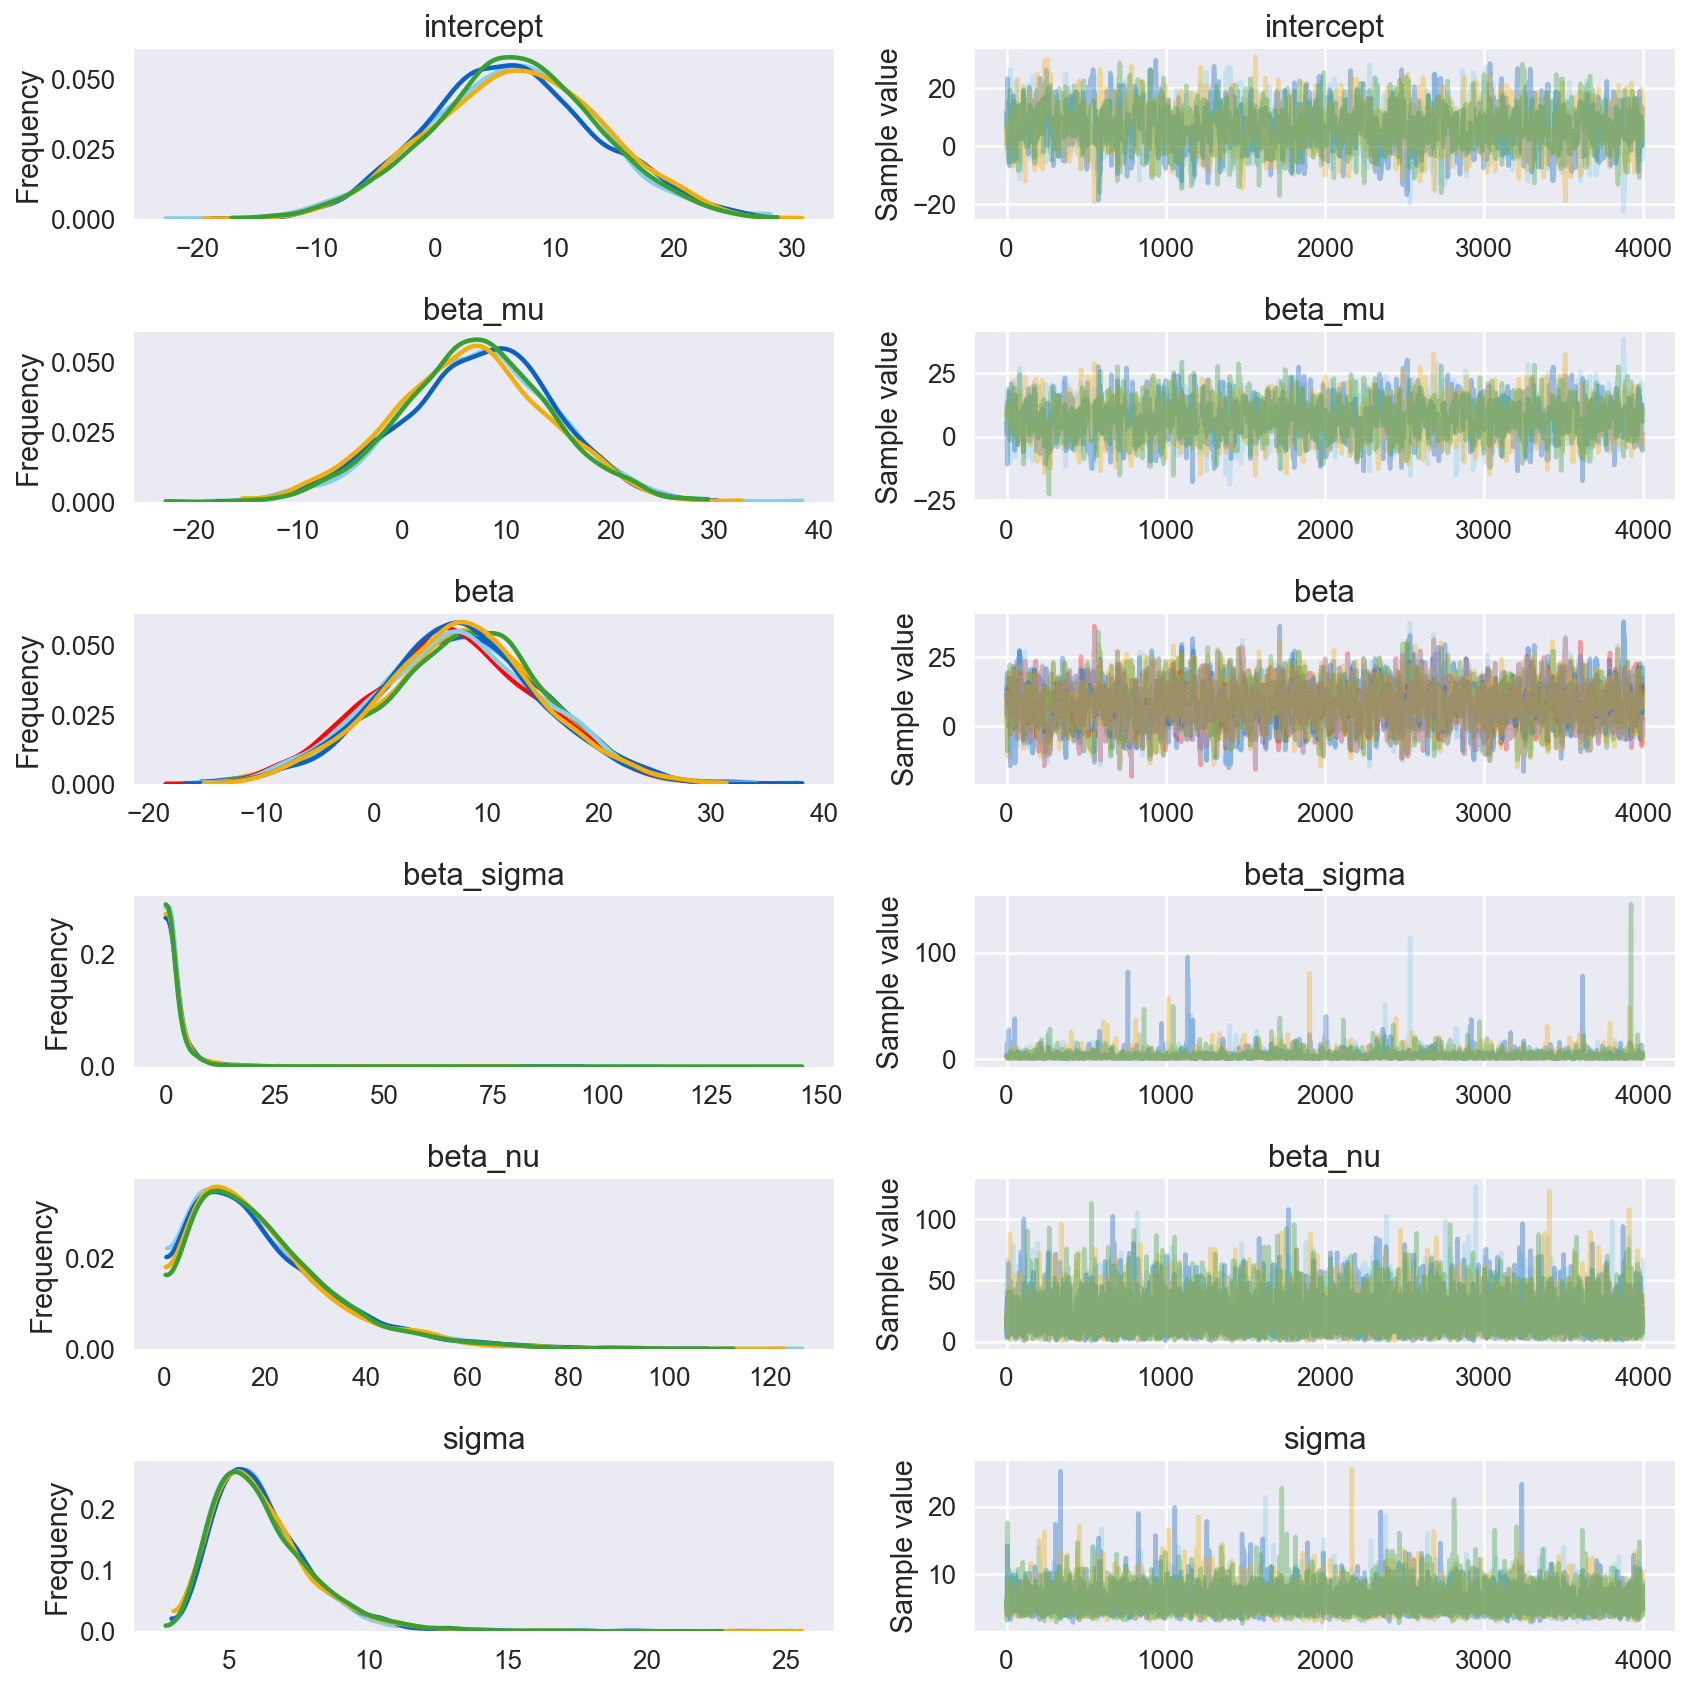

In [4]:
print(pm.df_summary(trace))
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x116aca150>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1179ac250>], dtype=object)

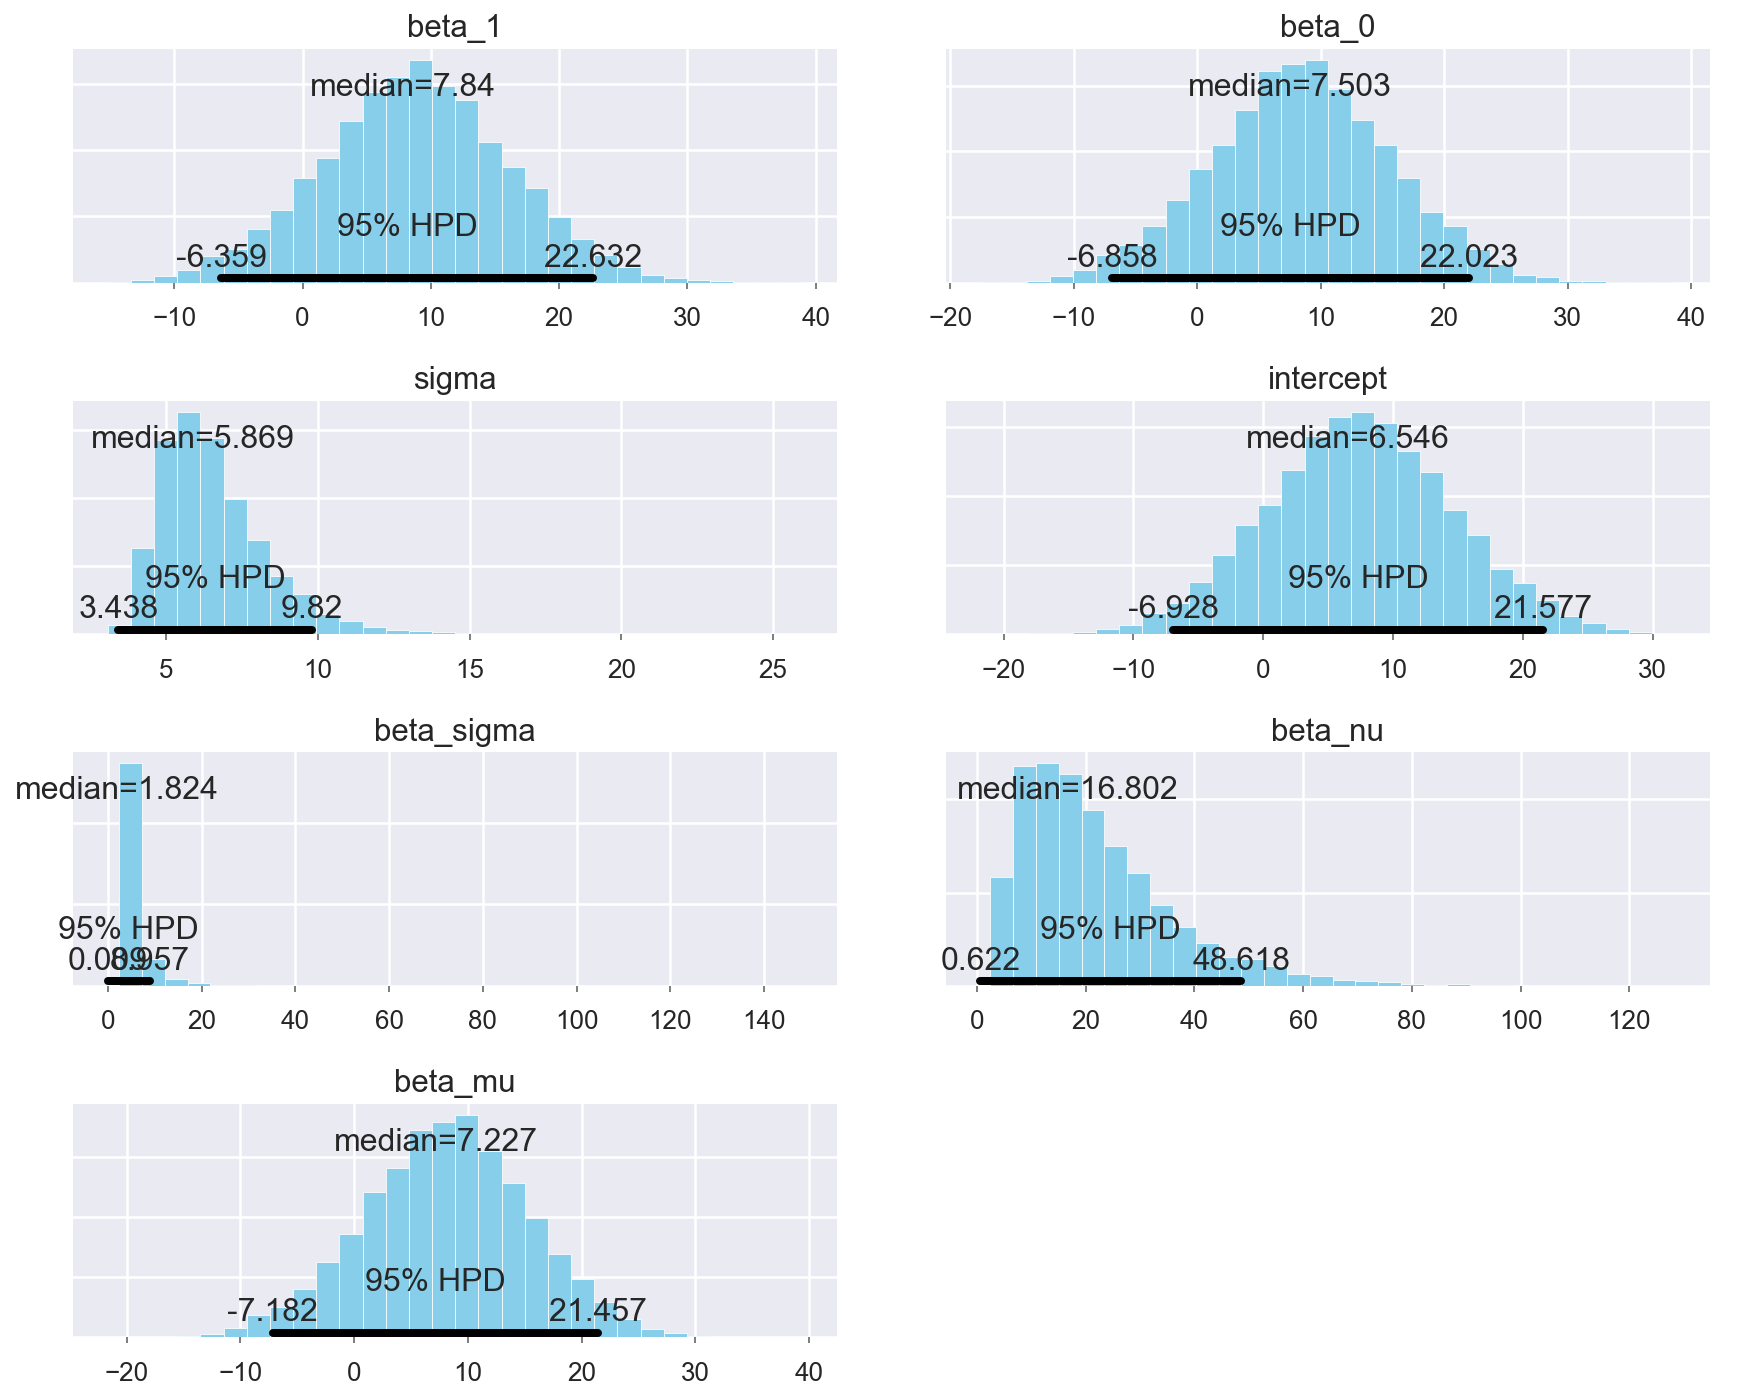

In [5]:
pm.plot_posterior(trace, point_estimate="median")

In [6]:
pm.diagnostics.gelman_rubin(trace)

{'beta': array([ 1.00061262,  1.00070549]),
 'beta_mu': 1.0009454435818028,
 'beta_nu': 0.99995382003519195,
 'beta_nu_log_': 1.0001143755181714,
 'beta_sigma': 1.0004546383770117,
 'beta_sigma_log_': 1.0000771122215899,
 'intercept': 1.0004075750552974,
 'sigma': 1.0000693461375207,
 'sigma_log_': 0.99998778807032973}

## Predictions

In [7]:
ppc = pm.sample_ppc(trace, samples=2000, model=model)

100%|██████████| 2000/2000 [00:16<00:00, 115.74it/s]


In [10]:
print(len(ppc["y"]))
ppc

2000


{'y': array([[  1.62505601,  22.02437868,  24.82214198, ...,  11.17717816,
          17.05727708,   8.50966047],
        [ 16.79128317,   6.23017627,  20.47314684, ...,  19.48907242,
          13.30031532,  21.66359536],
        [ 18.32471377,  14.0638205 ,  14.9426514 , ...,   7.82580834,
          10.89286332,   8.68369525],
        ..., 
        [ 14.09802369,  15.04086072,   4.17054497, ...,   2.35804155,
          16.34691448,   7.50247994],
        [ 21.82431984,  12.13421117,  12.11531678, ...,  10.99794076,
          19.37012454,  22.51853725],
        [  4.29838752,   7.8246739 ,  11.86084336, ...,   8.73673716,
           4.64150904,  10.96506131]])}

In [18]:
male = pd.Series(ppc["y"][:, :4].ravel())
female = pd.Series(ppc["y"][:, 4:].ravel())

print male.head()
print("\n")
print female.head()

0     1.625056
1    22.024379
2    24.822142
3    12.960387
4    16.791283
dtype: float64


0     8.465244
1    11.177178
2    17.057277
3     8.509660
4    10.183334
dtype: float64


In [19]:
print(male.describe())
print(female.describe())

count    8000.000000
mean       14.113939
std         6.976435
min       -19.517297
25%         9.870444
50%        14.164846
75%        18.412289
max        67.330120
dtype: float64
count    8000.000000
mean       14.303917
std         6.974883
min       -17.625676
25%        10.000456
50%        14.314723
75%        18.552484
max        55.362270
dtype: float64


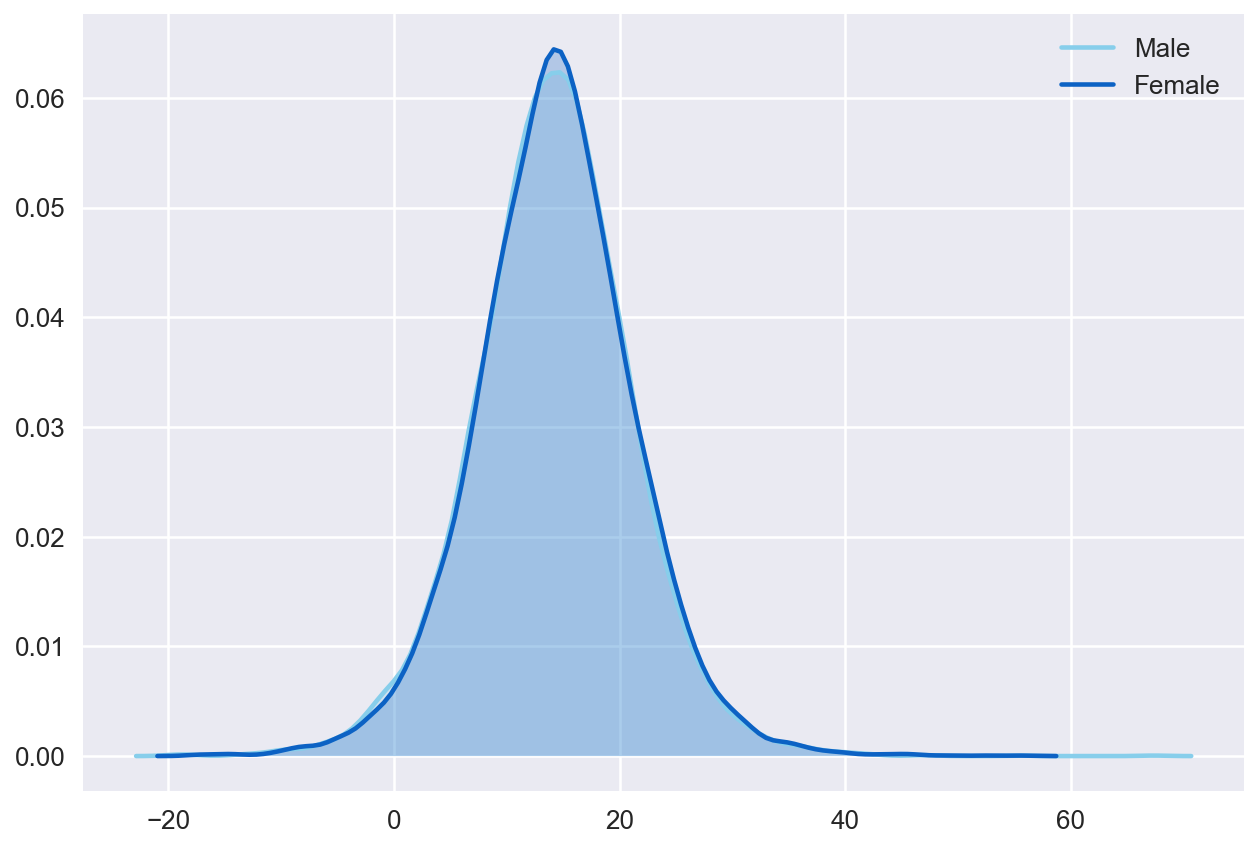

In [14]:
sns.kdeplot(male, shade=True, label="Male")
sns.kdeplot(female, shade=True, label="Female")

## Conclusion

The distributions are almost exactly the same!